# Figsetup
Using chou 20210504 unsort data.<br>
shortcaption: Temporal kernel of cells on MEA in the LED setup<br>
label: TK_MEA_OLED

In [1]:
filename = 'TK_MEA_OLED'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [4]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [5]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

In [6]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [7]:
figmap = [[np.nan, 7,15,23,31,39,47,np.nan],
          [     1, 8,16,24,32,40,48,    55],
          [     2, 9,17,25,33,41,49,    56],
          [     3,10,18,26,34,42,50,    57],
          [     4,11,19,27,35,43,51,    58],
          [     5,12,20,28,36,44,52,    59],
          [     6,13,21,29,37,45,53,    60],
          [np.nan,14,22,30,38,46,54,np.nan]]
figmap = np.array(figmap)
XOsave = True

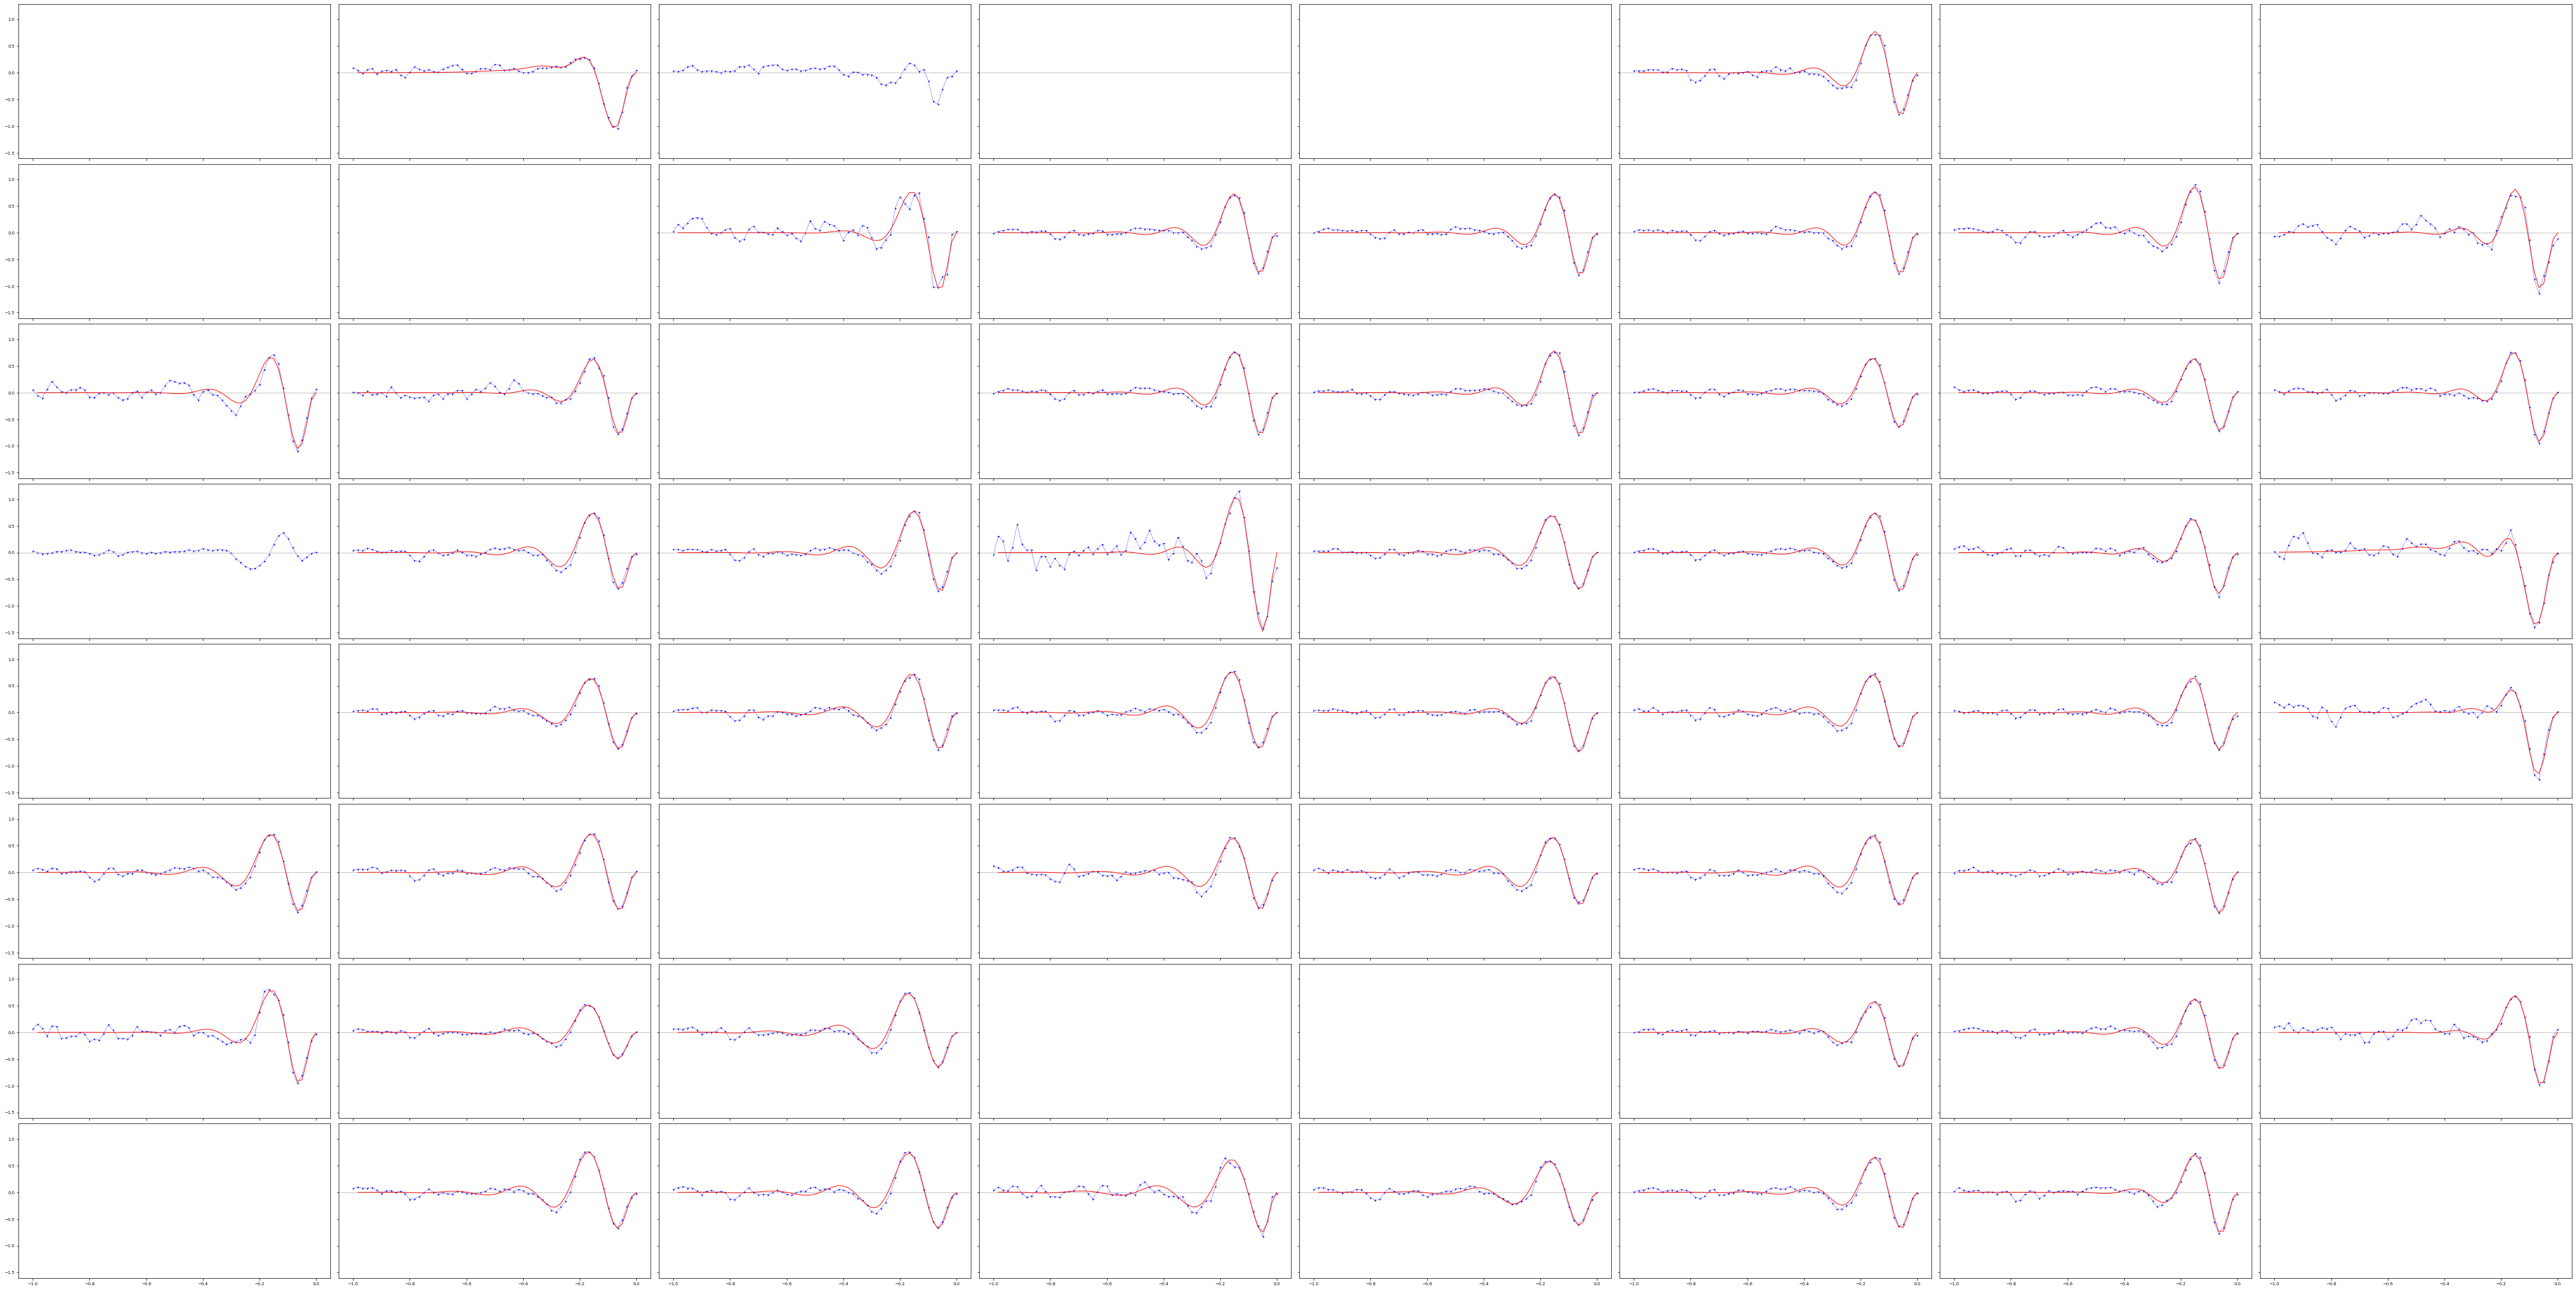

In [8]:
plt.rcParams["font.size"] = 7

annots = loadmat('D:\\GoogleDrive\\retina\\Chou\'s data\\20210504\\merge\\merge_0224_cSTA_wf_3min_Q100_re', squeeze_me = True)
x = annots['bin_pos']
x = (x-np.mean(x))/np.std(x)
dt = 1/60
cSTA_list = [0]*60
dcn = []
fig, ax = plt.subplots(nrows=8, ncols=8, constrained_layout=True, sharex=True, sharey=True)
fig.set_size_inches(60, 30)
for cn in range(60):
    spike = annots['reconstruct_spikes'][cn]
    rstate, _ = np.histogram(spike, np.arange(len(x)+1)*dt)

    cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
    cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
    taxis = -np.arange(len(cSTA))*dt
    if (np.abs(cSTA[:round(len(cSTA)/2)]) < 7*np.std(cSTA[round(len(cSTA)/2):-1])).all(): continue
    if sum(cSTA[:8]) < -1: dcn.append(cn) # exclude fitting of On-cell from fitting
    ax[np.where(figmap == cn+1)][0].plot(taxis, cSTA, 'b+:', linewidth = 1,markersize=3)
    ax[np.where(figmap == cn+1)][0].axhline(0, c='gray',alpha = 0.8, linewidth = 0.6)
    cSTA_list[cn] = cSTA

name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)
#-------------------------------------
fit_cSTA_list = [0]*60
para_dict['error'] = np.zeros(60)
for cn in dcn.copy():
#     for cn in [37]:
    epsilon = 10. #1/sec
    gamma = 25.
    omegastar = 30. 
    deltastar = 0.
    tau_y = 0.04
    Dmp = 10.
    try:
        popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis), cSTA_list[cn], 
                              p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                              bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                        [np.inf , np.inf, np.inf   ,  np.pi/2 , np.inf  , np.inf ] ))
    except:
        dcn.remove(cn)
        continue
    for l in range(len(popt)):
        para_dict[name_list[l]][cn] = popt[l]
#     print(popt)
    fit_cSTA_list[cn] = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
    para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
    ax[np.where(figmap == cn+1)][0].plot(taxis[:-1], fit_cSTA_list[cn][:-1], 'r-', linewidth = 1)

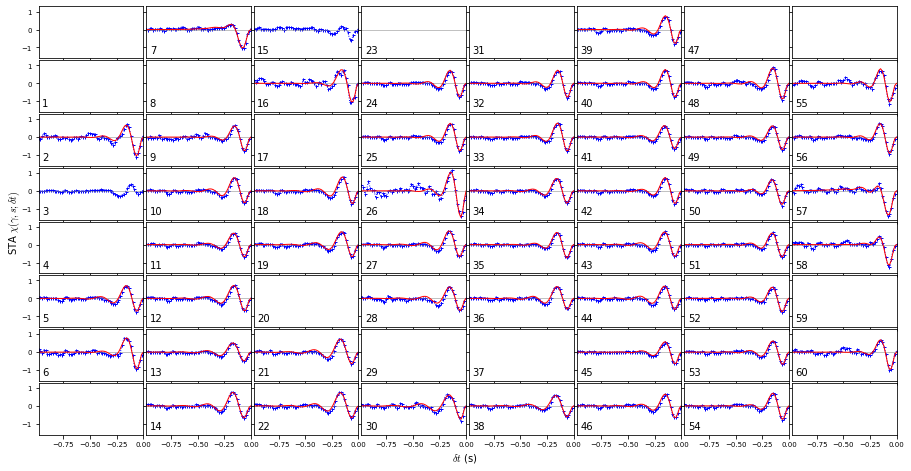

In [9]:
for ax1d in ax:
    for a in ax1d:
#         a.set_ylim([-1.6,1.2])
        a.set_xlim([-1.0+dt,0])

for cn in range(60):
    ax[np.where(figmap == cn+1)][0].text(-0.95, -1.3, str(cn+1), fontsize = 10)


fig.supxlabel(r'$\delta t$ (s)', y=-0.06, fontsize = 10)
fig.supylabel('STA $\chi(\gamma, s; \delta t)$ ', x=-0.03, fontsize = 10)


fig.set_size_inches(12, 6)
fig

In [10]:
# fig.set_size_inches(50, 25)
# fig.tight_layout()

fig.savefig('D:\\GoogleDrive\\retina\\thesis\\fig\\R\\'+filename+'.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)